### PINN approach for the 1-D duffing problem

$\ddot{x} + 2D\dot{x} + \omega_0^2(x + \mu x^3) = f(t)$

In [52]:
import torch
import torch.nn as nn
import torchphysics as tp
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training on', device)
print ("GPU available: " + str(torch.cuda.is_available()))

Training on cuda:0
GPU available: True


In [54]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

In [55]:
omega_0 = 1

ode_params = {'D': .01,      # damping constant
              'c_nlin': 0.5  # nonlinearity
             }
sampling_frequency = 10 
t_end = 100 # sec
time = np.linspace(0, t_end, t_end*sampling_frequency + 1)
time_ind = pd.to_timedelta(time, unit="sec")
f_fac = .025

### ODE solution

In [56]:
def duffing(t, y, D, c_nlin, F_func):
    z1, z2 = y
    dz1dt = z2
    dz2dt = - 2 * D * z2 - z1 - c_nlin * z1**3 + f_fac *  F_func(t)
    return(dz1dt, dz2dt)

F = pd.Series(np.random.randn(time.shape[0]),
              index=pd.Index(time, name="time")
              )# some white noise data on right hand site
F_inter_func = IUS(time, F, k=1)

x0 = [1, 0] # initial conditions
numeric_solu = solve_ivp(duffing,
                         t_span=(0, t_end),
                         y0 = x0,
                         max_step=1 / sampling_frequency,
                         args=(ode_params['D'], ode_params['c_nlin'], F_inter_func)
                        )

solu = pd.Series(numeric_solu.y[0,:], index=pd.Index(numeric_solu.t, name="time"))

<AxesSubplot:xlabel='time'>

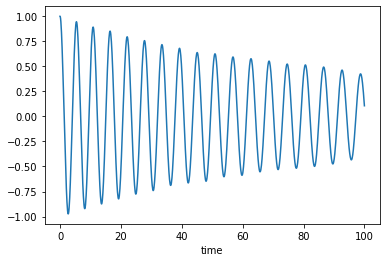

In [57]:
%matplotlib inline
solu.plot()

### PINN solution

In [58]:
T = tp.spaces.R1('t') # time
# Output
U = tp.spaces.R1('u')
# Intervals and domains and sampler
Dmin, Dmax = 0.01, 0.1
A_t = tp.domains.Interval(T, 0, t_end)
inner_sampler = tp.samplers.GridSampler(A_t, n_points = 1250).make_static()
    
initial_u_sampler = tp.samplers.GridSampler(A_t.boundary_left, n_points = 1).make_static()
initial_v_sampler = tp.samplers.GridSampler(A_t.boundary_left, n_points = 1).make_static()

In [59]:
#%% Model Definition
# model = tp.models.Sequential(
#     tp.models.NormalizationLayer(A_t),
#     tp.models.FCN(input_space=T, output_space=U, hidden=(20,20)))
class Snake(torch.nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, Tensor):
        a = 1
        return Tensor + (1.0/a) * torch.pow(torch.sin(Tensor * a), 2)

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, Tensor):
        return torch.sin(Tensor)

# model = tp.models.FCN(input_space=T, output_space=U, hidden=(24, 24, 16),
#                       activations=Sine() #Tanh(), RNN()
#                       )


model = tp.models.Sequential(
    tp.models.NormalizationLayer(A_t),
    tp.models.FCN(input_space=T, output_space=U, hidden=(32,32),
                  activations=Sine())
)
    

SyntaxError: unexpected EOF while parsing (<ipython-input-59-dfe917c3cc10>, line 31)

In [ ]:
def duffing_residual(u, t):
    
    fmin = tp.utils.laplacian(u, t)  + 2 * ode_params["D"] * tp.utils.grad(u, t) \
            + u + ode_params["c_nlin"] * u**3 # - rhs.cuda()
    return 10 * fmin # weighting of PDE = 10
            
pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=duffing_residual,
                                            name='pde_condition')

def initial_u_residual(u):
    return u-1
initial_u_condition = tp.conditions.PINNCondition(module=model,
                                                     sampler=initial_u_sampler,
                                                     residual_fn=initial_u_residual,
                                                     name='ic_u')

def initial_v_residual(u, t):
    return tp.utils.grad(u, t)
initial_v_condition = tp.conditions.PINNCondition(module=model,
                                                     sampler=initial_v_sampler,
                                                     residual_fn=initial_v_residual,
                                                     name='ic_v')
def right_hand_side(u, t):
    rhs = f_fac * torch.tensor(F_inter_func(t.detach().cpu().numpy()))
    
    return rhs.cuda() - u

rhs_condition = tp.conditions.PINNCondition(module=model,
                                    sampler=inner_sampler,
                                    residual_fn=right_hand_side,
                                    name='force')

In [ ]:
#%% Training
for opti, steps in zip([torch.optim.AdamW, torch.optim.LBFGS], [3500, 250]):
    opt_setting = tp.solver.OptimizerSetting(opti, lr=1e-2) #AdamW, SGD, LBFGS
    solver = tp.solver.Solver([pde_condition,
                               initial_u_condition,
                               initial_v_condition,
                               rhs_condition
                              ], optimizer_setting = opt_setting)
    
    trainer = pl.Trainer(gpus=1, # or 1 if GPU available
                         max_steps = steps,
                         logger=True, 
                         benchmark=False,
                         log_every_n_steps=10,
                         )
    trainer.fit(solver)

In [ ]:
#%% Prediction
time_tensor = torch.tensor(time)

grid_sampler = tp.samplers.GridSampler(A_t, n_points=len(solu)) #+ tp.samplers.GridSampler(A_t.boundary, n_points=1)
grid_points = grid_sampler.sample_points()
                        # )
model_out = model(grid_points)
pinn_solu = pd.Series(np.interp(solu.index, grid_points.as_tensor.detach().numpy().ravel(), 
                                model_out.as_tensor.detach().numpy().ravel()),
                      index=solu.index
                     )
solu_comb = pd.concat((solu, pinn_solu), axis=1)

In [ ]:
solu_comb.plot()